<a href="https://colab.research.google.com/github/lucasoteroo/IA/blob/main/IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import warnings
from sklearn.exceptions import ConvergenceWarning

# Download latest version
path = kagglehub.dataset_download("prince7489/car-price-prediction-dataset")

print("Path to dataset files:", path)


warnings.filterwarnings("ignore", category=ConvergenceWarning)

Using Colab cache for faster access to the 'car-price-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/car-price-prediction-dataset


In [ ]:


# Supondo que df já esteja carregado
print(df.columns)


Index(['Car_ID', 'Brand', 'Model_Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Engine_CC', 'Max_Power_bhp',
       'Mileage_kmpl', 'Seats', 'Price_USD', 'price_category'],
      dtype='object')


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

                 Model                        Param  Accuracy_mean  \
2         DecisionTree                 max_depth=15          0.532   
6           GaussianNB          var_smoothing=1e-09          0.526   
7           GaussianNB          var_smoothing=1e-08          0.526   
3                  KNN                n_neighbors=3          0.524   
1         DecisionTree                 max_depth=10          0.576   
4                  KNN                n_neighbors=5          0.540   
5                  KNN                n_neighbors=7          0.582   
0         DecisionTree                  max_depth=5          0.644   
11       MLPClassifier     hidden_layer_sizes=(50,)          0.649   
13       MLPClassifier  hidden_layer_sizes=(50, 50)          0.649   
12       MLPClassifier    hidden_layer_sizes=(100,)          0.650   
8   LogisticRegression                        C=0.1          0.659   
9   LogisticRegression                          C=1          0.657   
10  LogisticRegressi

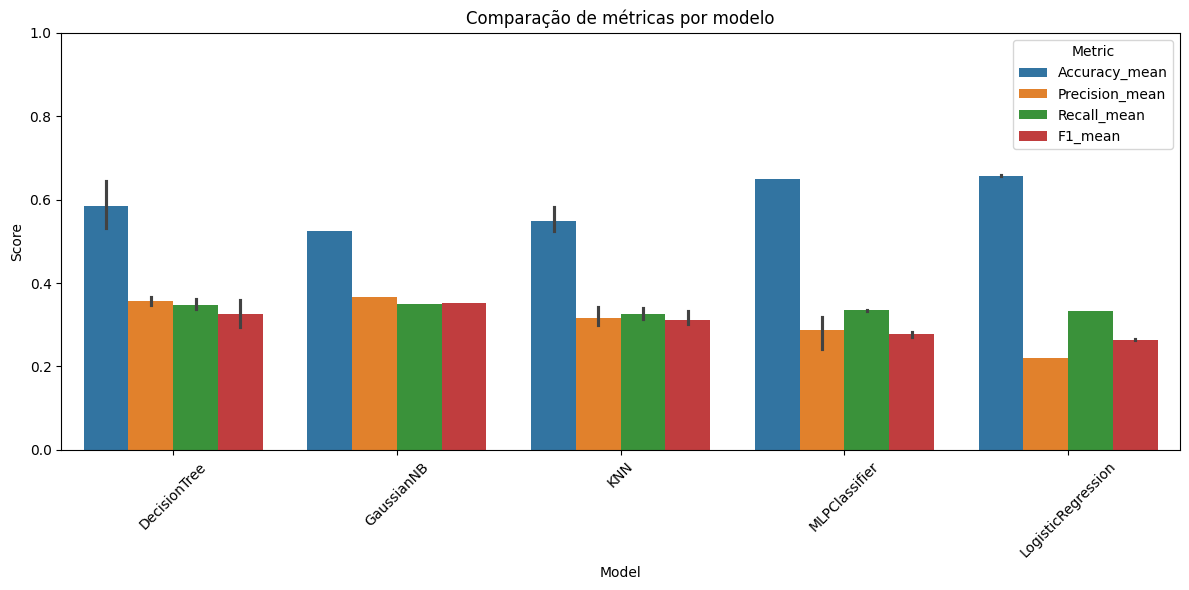

✔ Base original salva como 'cars_original.csv'
✔ Base processada salva como 'cars_preprocessed.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)



# -------------------------------
# Criar bins realistas de preço


bins = [0, 20000, 40000, np.inf]
labels = [0, 1, 2]

df["price_category"] = pd.cut(df["Price_USD"], bins=bins, labels=labels).astype(int)



# ------------------------------------------------
# 2) Pré-processamento
# ------------------------------------------------
X = df.drop(columns=["Price_USD", "price_category", "Car_ID"])
y = df["price_category"]

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------
# 3) Modelos e parâmetros
# ------------------------------------------------
models = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [5, 10, 15]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7]}
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {"var_smoothing": [1e-9, 1e-8]}
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "params": {"C": [0.1, 1, 10]}
    },
    "MLPClassifier": {
        "model": MLPClassifier(
            solver='adam',
            max_iter=3000,
            early_stopping=True,
            random_state=42
        ),
        "params": {"hidden_layer_sizes": [(50,), (100,), (50,50)]}
    }
}

# ------------------------------------------------
# 4) 10-fold Stratified CV
# ------------------------------------------------
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []

for name, mp in models.items():
    model = mp["model"]
    for param_name in mp["params"]:
        for param_value in mp["params"][param_name]:
            model.set_params(**{param_name: param_value})

            scores = cross_validate(
                model, X_scaled, y, cv=skf,
                scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"]
            )

            results.append({
                "Model": name,
                "Param": f"{param_name}={param_value}",
                "Accuracy_mean": np.mean(scores["test_accuracy"]),
                "Accuracy_std": np.std(scores["test_accuracy"]),
                "Precision_mean": np.mean(scores["test_precision_macro"]),
                "Precision_std": np.std(scores["test_precision_macro"]),
                "Recall_mean": np.mean(scores["test_recall_macro"]),
                "Recall_std": np.std(scores["test_recall_macro"]),
                "F1_mean": np.mean(scores["test_f1_macro"]),
                "F1_std": np.std(scores["test_f1_macro"])
            })

df_results = pd.DataFrame(results)

# ------------------------------------------------
# 5) Ordenar e mostrar tabela
# ------------------------------------------------
df_results_sorted = df_results.sort_values(by="F1_mean", ascending=False)
print(df_results_sorted)

# ------------------------------------------------
# 6) Gráfico
# ------------------------------------------------
plt.figure(figsize=(12,6))
metrics = ["Accuracy_mean", "Precision_mean", "Recall_mean", "F1_mean"]
df_melted = df_results_sorted.melt(id_vars=["Model", "Param"], value_vars=metrics,
                                   var_name="Metric", value_name="Score")
sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
plt.title("Comparação de métricas por modelo")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


# ======================================================
# 7) Salvar bases original e processada
# ======================================================

# 1. Base original (antes de qualquer pré-processamento)
df.to_csv("cars_original.csv", index=False, encoding="utf-8")
print("✔ Base original salva como 'cars_original.csv'")

# 2. Base processada (apenas atributos usados no modelo + target)
df_preprocessed = pd.DataFrame(X_scaled, columns=X.columns)
df_preprocessed["price_category"] = y.values

df_preprocessed.to_csv("cars_preprocessed.csv", index=False, encoding="utf-8")
print("✔ Base processada salva como 'cars_preprocessed.csv'")


Using Colab cache for faster access to the 'car-price-prediction-dataset' dataset.
Path: /kaggle/input/car-price-prediction-dataset
Files in dataset: ['car_price_dataset_medium.csv']
✔ DataFrame carregado com sucesso.
   Car_ID     Brand  Model_Year  Kilometers_Driven Fuel_Type Transmission  \
0       1      Audi        2005             197018    Diesel       Manual   
1       2       BMW        2019              43467    Hybrid    Automatic   
2       3       Kia        2012             153697    Hybrid    Automatic   
3       4  Mercedes        2015              38893    Petrol    Automatic   
4       5      Audi        2016              81329    Hybrid    Automatic   

  Owner_Type  Engine_CC  Max_Power_bhp  Mileage_kmpl  Seats  Price_USD  
0      First       4046          223.6         29.61      6  119611.94  
1      First       3731          248.4         21.66      5   90842.46  
2      Third       4925          465.5         12.14      6   78432.24  
3     Second       3771    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

                 Model                        Param  Accuracy_mean  \
2         DecisionTree                 max_depth=15          0.532   
6           GaussianNB          var_smoothing=1e-09          0.526   
7           GaussianNB          var_smoothing=1e-08          0.526   
3                  KNN                n_neighbors=3          0.524   
1         DecisionTree                 max_depth=10          0.576   
4                  KNN                n_neighbors=5          0.540   
5                  KNN                n_neighbors=7          0.582   
0         DecisionTree                  max_depth=5          0.644   
11       MLPClassifier     hidden_layer_sizes=(50,)          0.649   
13       MLPClassifier  hidden_layer_sizes=(50, 50)          0.649   
12       MLPClassifier    hidden_layer_sizes=(100,)          0.650   
8   LogisticRegression                        C=0.1          0.659   
9   LogisticRegression                          C=1          0.657   
10  LogisticRegressi

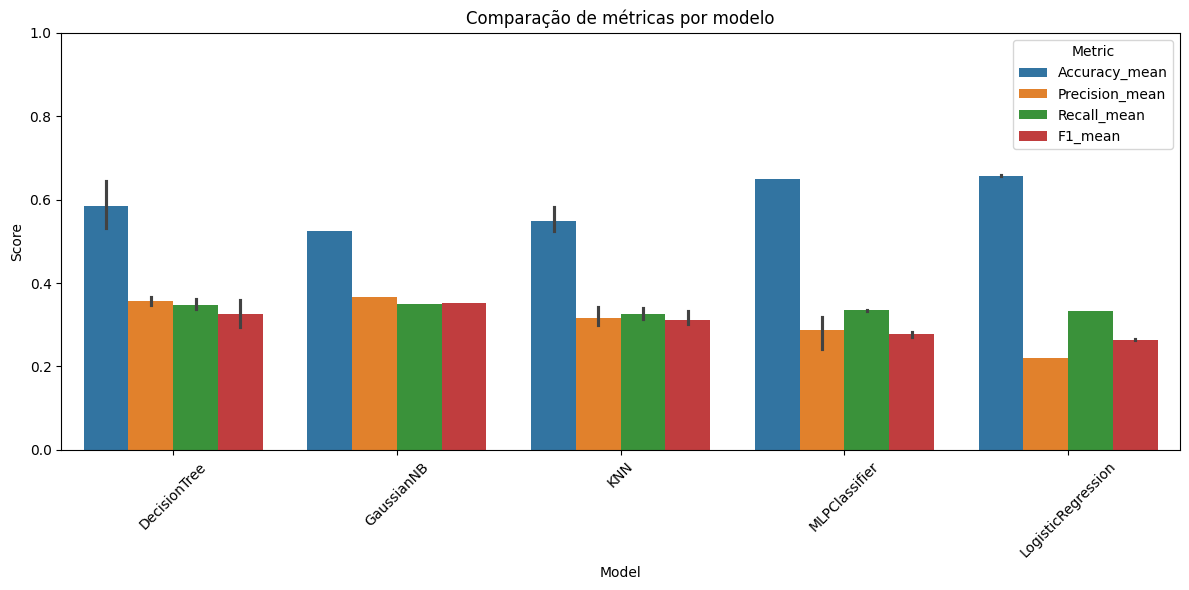

✔ Base original salva como 'cars_original.csv'
✔ Base processada salva como 'cars_preprocessed.csv'


In [ ]:
# ============================
# 1) IMPORTS
# ============================
import kagglehub
import warnings
from sklearn.exceptions import ConvergenceWarning
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)


# ============================
# 2) DOWNLOAD DO DATASET
# ============================
path = kagglehub.dataset_download("prince7489/car-price-prediction-dataset")
print("Path:", path)

# Listar arquivos baixados
print("Files in dataset:", os.listdir(path))

# Descobrir arquivo CSV automaticamente
csv_files = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
if len(csv_files) == 0:
    raise FileNotFoundError("Nenhum arquivo CSV encontrado no dataset!")
elif len(csv_files) > 1:
    print("Vários CSV encontrados, usando o primeiro:", csv_files[0])

csv_name = csv_files[0]

# Carregar DataFrame
df = pd.read_csv(os.path.join(path, csv_name))
print("✔ DataFrame carregado com sucesso.")
print(df.head())
print(df.columns)


# ============================
# 3) Criar bins de preço
# ============================
bins = [0, 20000, 40000, np.inf]
labels = [0, 1, 2]

df["price_category"] = pd.cut(df["Price_USD"], bins=bins, labels=labels).astype(int)


# ============================
# 4) Pré-processamento
# ============================
X = df.drop(columns=["Price_USD", "price_category", "Car_ID"])
y = df["price_category"]

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ============================
# 5) Modelos e parâmetros
# ============================
models = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [5, 10, 15]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7]}
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {"var_smoothing": [1e-9, 1e-8]}
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=2000, random_state=42),
        "params": {"C": [0.1, 1, 10]}
    },
    "MLPClassifier": {
        "model": MLPClassifier(
            solver='adam',
            max_iter=3000,
            early_stopping=True,
            random_state=42
        ),
        "params": {"hidden_layer_sizes": [(50,), (100,), (50, 50)]}
    }
}


# ============================
# 6) 10-fold Stratified CV
# ============================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []

for name, mp in models.items():
    model = mp["model"]
    for param_name in mp["params"]:
        for param_value in mp["params"][param_name]:
            model.set_params(**{param_name: param_value})

            scores = cross_validate(
                model, X_scaled, y, cv=skf,
                scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"]
            )

            results.append({
                "Model": name,
                "Param": f"{param_name}={param_value}",
                "Accuracy_mean": np.mean(scores["test_accuracy"]),
                "Accuracy_std": np.std(scores["test_accuracy"]),
                "Precision_mean": np.mean(scores["test_precision_macro"]),
                "Precision_std": np.std(scores["test_precision_macro"]),
                "Recall_mean": np.mean(scores["test_recall_macro"]),
                "Recall_std": np.std(scores["test_recall_macro"]),
                "F1_mean": np.mean(scores["test_f1_macro"]),
                "F1_std": np.std(scores["test_f1_macro"])
            })

df_results = pd.DataFrame(results)


# ============================
# 7) Resultados ordenados
# ============================
df_results_sorted = df_results.sort_values(by="F1_mean", ascending=False)
print(df_results_sorted)


# ============================
# 8) Gráfico comparativo
# ============================
plt.figure(figsize=(12, 6))
metrics = ["Accuracy_mean", "Precision_mean", "Recall_mean", "F1_mean"]

df_melted = df_results_sorted.melt(
    id_vars=["Model", "Param"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Score"
)

sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric")
plt.title("Comparação de métricas por modelo")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# ============================
# 9) Salvar bases
# ============================

# Base original
df.to_csv("cars_original.csv", index=False, encoding="utf-8")
print("✔ Base original salva como 'cars_original.csv'")

# Base processada
df_preprocessed = pd.DataFrame(X_scaled, columns=X.columns)
df_preprocessed["price_category"] = y.values

df_preprocessed.to_csv("cars_preprocessed.csv", index=False, encoding="utf-8")
print("✔ Base processada salva como 'cars_preprocessed.csv'")
